# Comparison to Kruk (2018)

In [1]:
import os
from os.path import join
import re
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from astropy.coordinates import SkyCoord
import astropy.units as u

import gzbuilder_analysis.parsing as pg

In [2]:
gal_angle_df = pd.read_csv('lib/gal-metadata.csv', index_col=0)
sd = pd.read_csv('../source_files/Kruk2018_Table2_Table3.csv')
sd_coords = SkyCoord(ra=sd['ra']*u.degree, dec=sd['dec']*u.degree)

In [3]:
agg_res_path = 'output_files/aggregation_results'
agg_results = pd.Series([], dtype=object)
with tqdm(os.listdir(agg_res_path)) as bar:
    for f in bar:
         if re.match(r'[0-9]+\.pkl.gz', f):
                agg_results[int(f.split('.')[0])] = pd.read_pickle(
                    os.path.join(agg_res_path, f)
                )

100%|██████████| 296/296 [00:03<00:00, 78.89it/s] 


In [4]:
fit_model_path = 'output_files/tuning_results'
fit_models = pd.Series([], dtype=object)
with tqdm(os.listdir(fit_model_path)) as bar:
    for f in bar:
         if re.match(r'[0-9]+\.pickle.gz', f):
                fit_models[int(f.split('.')[0])] = pd.read_pickle(
                    os.path.join(fit_model_path, f)
                )
fit_models = fit_models.apply(pd.Series)

100%|██████████| 297/297 [00:00<00:00, 389.55it/s]


In [5]:
matches = pd.DataFrame([], columns=sd.columns)
with tqdm(agg_results.index) as bar:
    for subject_id in bar:
        gal = gal_angle_df.loc[subject_id]
        sep = sd_coords.separation(
            SkyCoord(ra=gal['RA']*u.degree, dec=gal['DEC']*u.degree)
        )
        idxmin_sep = np.argmin(sep)
        if sep[idxmin_sep] < 1 * u.arcsec:
            matches.loc[subject_id] = sd.iloc[idxmin_sep]

100%|██████████| 296/296 [00:01<00:00, 148.88it/s]


In [6]:
disks = agg_results.apply(lambda res: res.params.get('disk', default=pd.Series([], dtype='float')))
bulges = agg_results.apply(lambda res: res.params.get('bulge', default=pd.Series([], dtype='float')))
bars = agg_results.apply(lambda res: res.params.get('bar', default=pd.Series([], dtype='float')))

disks_e = agg_results.apply(lambda res: res.errors.get('disk', default=pd.Series([], dtype='float')))
bulges_e = agg_results.apply(lambda res: res.errors.get('bulge', default=pd.Series([], dtype='float')))
bars_e = agg_results.apply(lambda res: res.errors.get('bar', default=pd.Series([], dtype='float')))

In [7]:
fit_model_dicts = fit_models['final_model'].apply(pg.sanitize_model).apply(pd.Series)
fit_disks = fit_model_dicts.disk.apply(pd.Series)
fit_bulges = fit_model_dicts.bulge.apply(pd.Series)
fit_bars = fit_model_dicts.bar.apply(pd.Series)

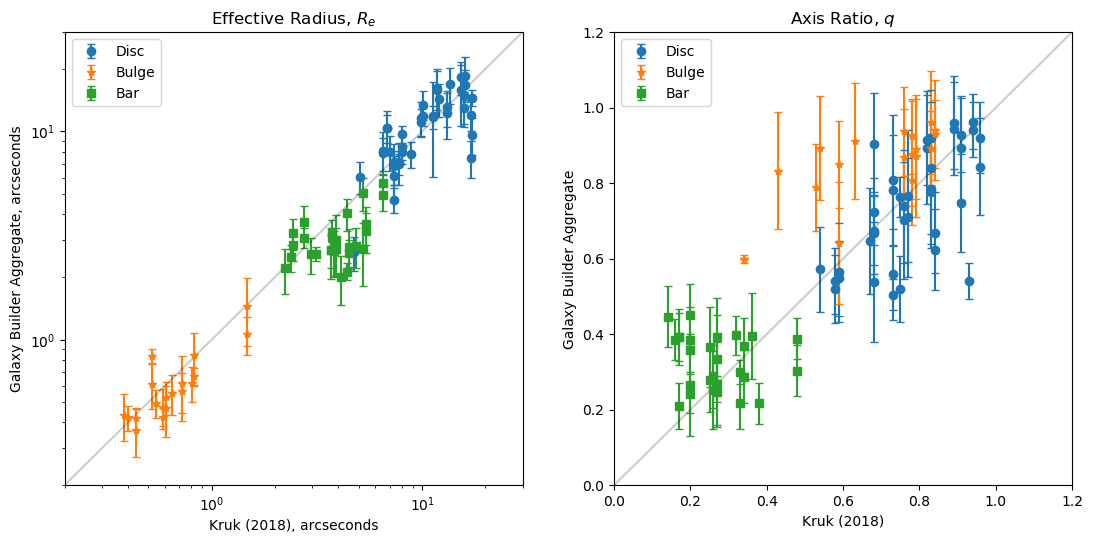

In [8]:
labels = ('Disc', 'Bulge', 'Bar')
fmts = ['o', '*', 's']
f, ax = plt.subplots(ncols=2, figsize=(13, 6), dpi=100)
plt.sca(ax[0])
for i, re_df in enumerate((
    pd.concat((
        disks.Re,
        matches['re_disc'].rename('sk'),
        disks_e.Re.rename('err')
    ), axis=1) * 0.396,
    pd.concat((
        bulges.Re,
        matches['re_bulge'].rename('sk'),
        bulges_e.Re.rename('err')
    ), axis=1) * 0.396,
    pd.concat((
        bars.Re,
        matches['re_bar'].rename('sk'),
        bars_e.Re.rename('err')
    ), axis=1) * 0.396,
)):
    re_df = re_df.dropna()
    plt.errorbar(
        re_df['sk'], re_df['Re'], yerr=re_df['err'],
        fmt=fmts[i], capsize=3, label=labels[i]
    )
plt.legend()
plt.gca().add_line(plt.Line2D((0, 3000), (0, 3000), c='k', alpha=0.2))
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.2, 30) 
plt.ylim(0.2, 30)
plt.title(r'Effective Radius, $R_e$')
plt.xlabel('Kruk (2018), arcseconds')
plt.ylabel('Galaxy Builder Aggregate, arcseconds')
plt.sca(ax[1])
for i, re_df in enumerate((
    pd.concat((disks.q, matches['ba_disc'].rename('sk'), disks_e.q.rename('err')), axis=1),
    pd.concat((bulges.q, matches['ba_bulge'].rename('sk'), bulges_e.q.rename('err')), axis=1),
    pd.concat((bars.q, matches['ba_bar'].rename('sk'), bars_e.q.rename('err')), axis=1),
)):
    re_df = re_df.replace(0, np.nan).dropna()
    plt.errorbar(
        re_df['sk'], re_df['q'], yerr=re_df['err'],
        fmt=fmts[i], capsize=3, label=labels[i]
    )
plt.legend()
plt.gca().add_line(plt.Line2D((0, 100), (0, 100), c='k', alpha=0.2))
plt.xlim(0, 1.2) 
plt.ylim(0, 1.2)
plt.title(r'Axis Ratio, $q$')
plt.xlabel('Kruk (2018)')
plt.ylabel('Galaxy Builder Aggregate')
plt.savefig('method-paper-plots/sd_comp_comparison.pdf', bbox_inches='tight')

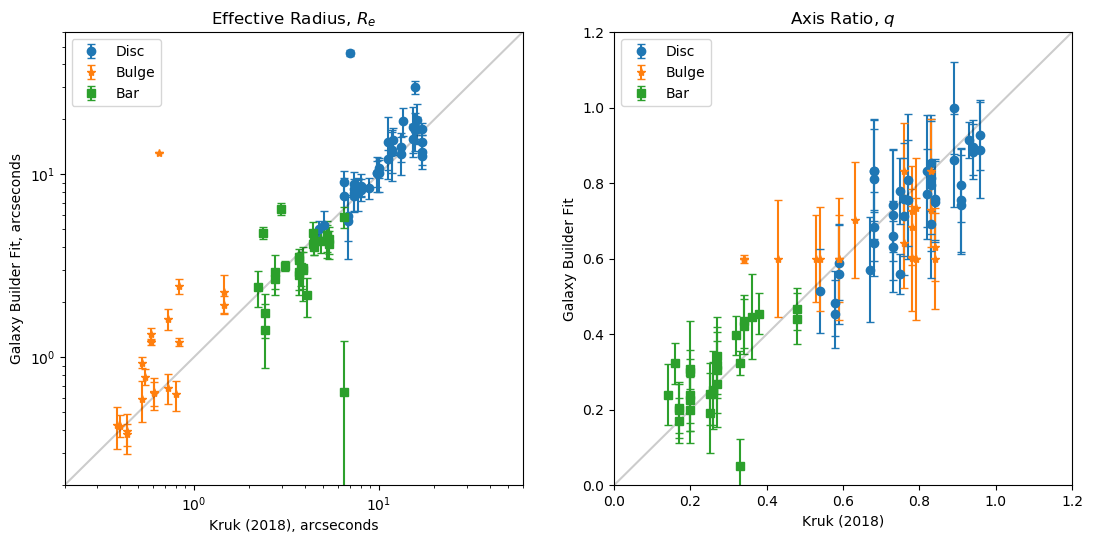

In [9]:
labels = ('Disc', 'Bulge', 'Bar')
fmts = ['o', '*', 's']
f, ax = plt.subplots(ncols=2, figsize=(13, 6), dpi=100)
plt.sca(ax[0])
for i, re_df in enumerate((
    pd.concat((
        fit_disks.Re,
        matches['re_disc'].rename('sk'),
        disks_e.Re.rename('err')
    ), axis=1) * 0.396,
    pd.concat((
        fit_bulges.Re,
        matches['re_bulge'].rename('sk'),
        bulges_e.Re.rename('err')
    ), axis=1) * 0.396,
    pd.concat((
        fit_bars.Re,
        matches['re_bar'].rename('sk'),
        bars_e.Re.rename('err')
    ), axis=1) * 0.396,
)):
    re_df = re_df.dropna()
    plt.errorbar(
        re_df['sk'], re_df['Re'], yerr=re_df['err'],
        fmt=fmts[i], capsize=3, label=labels[i]
    )
plt.legend()
plt.gca().add_line(plt.Line2D((0, 300), (0, 300), c='k', alpha=0.2))
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.2, 60) 
plt.ylim(0.2, 60)
plt.title(r'Effective Radius, $R_e$')
plt.xlabel('Kruk (2018), arcseconds')
plt.ylabel('Galaxy Builder Fit, arcseconds')
plt.sca(ax[1])
for i, re_df in enumerate((
    pd.concat((fit_disks.q, matches['ba_disc'].rename('sk'), disks_e.q.rename('err')), axis=1),
    pd.concat((fit_bulges.q, matches['ba_bulge'].rename('sk'), bulges_e.q.rename('err')), axis=1),
    pd.concat((fit_bars.q, matches['ba_bar'].rename('sk'), bars_e.q.rename('err')), axis=1),
)):
    re_df = re_df.replace(0, np.nan).dropna()
    plt.errorbar(
        re_df['sk'], re_df['q'], yerr=re_df['err'],
        fmt=fmts[i], capsize=3, label=labels[i]
    )
plt.legend()
plt.gca().add_line(plt.Line2D((0, 100), (0, 100), c='k', alpha=0.2))
plt.xlim(0, 1.2) 
plt.ylim(0, 1.2)
plt.title(r'Axis Ratio, $q$')
plt.xlabel('Kruk (2018)')
plt.ylabel('Galaxy Builder Fit')
plt.savefig('method-paper-plots/sd_comp_comparison_fitted.pdf', bbox_inches='tight')

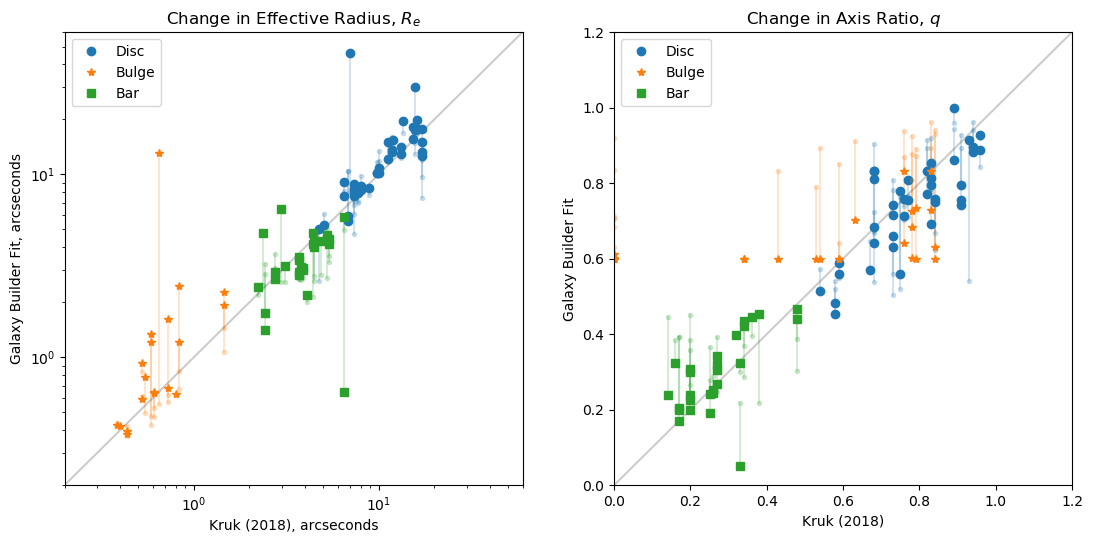

In [10]:
labels = ('Disc', 'Bulge', 'Bar')
fmts = ['o', '*', 's']
f, ax = plt.subplots(ncols=2, figsize=(13, 6), dpi=100)
plt.sca(ax[0])
for i, df in enumerate((
    pd.concat((
        disks.Re.rename('agg_Re'),
        fit_disks.Re,
        matches['re_disc'].rename('sk'),
        disks_e.Re.rename('err')
    ), axis=1) * 0.396,
    pd.concat((
        bulges.Re.rename('agg_Re'),
        fit_bulges.Re,
        matches['re_bulge'].rename('sk'),
        bulges_e.Re.rename('err')
    ), axis=1) * 0.396,
    pd.concat((
        bars.Re.rename('agg_Re'),
        fit_bars.Re,
        matches['re_bar'].rename('sk'),
        bars_e.Re.rename('err')
    ), axis=1) * 0.396,
)):
    df = df.dropna()
    plt.errorbar(
        df.sk, df.agg_Re, #yerr=re_df['err'],
        fmt='.', capsize=3, alpha=0.2, c=f'C{i}',
    )

    plt.plot(df.sk.values.repeat(2).reshape(-1, 2).T, np.stack((df.agg_Re, df.Re)), c=f'C{i}', alpha=0.2);
    plt.errorbar(
        df.sk, df.Re, #yerr=re_df['err'],
        fmt=fmts[i], capsize=3, label=labels[i], c=f'C{i}',
    )
plt.legend()
plt.gca().add_line(plt.Line2D((0, 300), (0, 300), c='k', alpha=0.2))
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.2, 60) 
plt.ylim(0.2, 60)
plt.title(r'Change in Effective Radius, $R_e$')
plt.xlabel('Kruk (2018), arcseconds')
plt.ylabel('Galaxy Builder Fit, arcseconds')
plt.sca(ax[1])
for i, df in enumerate((
    pd.concat((disks.q.rename('agg_q'), fit_disks.q, matches['ba_disc'].rename('sk'), disks_e.q.rename('err')), axis=1),
    pd.concat((bulges.q.rename('agg_q'), fit_bulges.q, matches['ba_bulge'].rename('sk'), bulges_e.q.rename('err')), axis=1),
    pd.concat((bars.q.rename('agg_q'), fit_bars.q, matches['ba_bar'].rename('sk'), bars_e.q.rename('err')), axis=1),
)):
    df = df.dropna()
    plt.errorbar(
        df.sk, df.agg_q, #yerr=re_df['err'],
        fmt='.', capsize=3, alpha=0.2, c=f'C{i}',
    )

    plt.plot(df.sk.values.repeat(2).reshape(-1, 2).T, np.stack((df.agg_q, df.q)), c=f'C{i}', alpha=0.2);
    plt.errorbar(
        df.sk, df.q, #yerr=re_df['err'],
        fmt=fmts[i], capsize=3, label=labels[i], c=f'C{i}',
    )
plt.legend()
plt.gca().add_line(plt.Line2D((0, 100), (0, 100), c='k', alpha=0.2))
plt.xlim(0, 1.2) 
plt.ylim(0, 1.2)
plt.title(r'Change in Axis Ratio, $q$')
plt.xlabel('Kruk (2018)')
plt.ylabel('Galaxy Builder Fit')
plt.savefig('method-paper-plots/sd_comp_comparison_change.pdf', bbox_inches='tight')